In [312]:
%matplotlib inline
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [313]:
%autoreload 2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy.ndimage import gaussian_filter
import xarray as xr

import os,sys,glob
import re

## Add own library to path
workdir = os.getcwd()
repodir = workdir
projectname = 'EUREC4A'
while os.path.basename(repodir) != projectname:
    repodir = os.path.dirname(repodir)
print('repo:',repodir)
thismodule = sys.modules[__name__]

inputdir = os.path.join(repodir,'input/ATR-42/SAFIRE/Radiometer-CLIMAT-CE332',)
figdir = os.path.join(repodir,'figures')
moviedir = os.path.join(repodir,'movies')

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

repo: /Users/bfildier/Code/analyses/EUREC4A/EUREC4A


In [314]:
allfiles = glob.glob(os.path.join(inputdir,'ATR*.nc'))
print(len(allfiles),' files available')

alldata = []
for file in allfiles:
    alldata.append(xr.open_dataset(file))

8  files available


In [315]:
i_file = 6
data = alldata[i_file]
print('file: %s'%os.path.basename(allfiles[i_file]))

file: ATR_RADIOMETER-CE332_20200126_as200003_V1.nc


In [316]:
wlengths = np.array([8.7,10.8,12.0])
print('wavelengths:',wlengths)

wavelengths: [ 8.7 10.8 12. ]


In [317]:
wnumbs = 10000/wlengths
print('wavenumbers:',wnumbs)

wavenumbers: [1149.42528736  925.92592593  833.33333333]


In [325]:
def showTbAndZ(data,between=slice(None),mask=None):
        
        
    # mask
    if mask is None:
        mask = np.zeros(data.time.size,dtype=bool)

    # create figure and labels
    fig,ax = plt.subplots(figsize=(15,5))
#     labels = [r'$\lambda = %2.1f \mu m, \nu = %4.0f cm^{-1}$'%(lam,nu) for (lam,nu) in zip(wlengths,wnumbs)]
    labels = [r'$\lambda = %2.1f \mu m$'%(lam) for lam in wlengths]
    varids = ['BRIGHTNESS_TEMPERATURE_C1','BRIGHTNESS_TEMPERATURE_C2','BRIGHTNESS_TEMPERATURE_C3']
    
    # show Tb for three canals
    for i in range(3):
        data_show = data[varids[i]].copy()
        data_show[mask] = np.nan
        data_show[between].plot(alpha=0.5,label=labels[i])

    # show altitude
    ax_r = ax.twinx()
    data_show = data.ALTITUDE.copy()
    data_show[mask] = np.nan
    data_show[between].plot(label='height (m)')
    
    # make legend
    ax.legend()
    ax_r.legend(loc='upper right')
    
#     plt.show()


In [319]:
def getVarMask(var,thres,deriv=False,filt_width=0,center=0,outside=False,above=True):
    
    # smooth if necessary
    values = gaussian_filter(var,filt_width)
    
    # get derivative if necessary
    if deriv:
        values = np.append(np.diff(values),np.nan)
    
    if outside:
        values = np.absolute(values-center)
    
    # take mask
    if above:
        return values > thres
    else:
        return values <= thres

def mergeMasks(mask_list):
    
    base_mask = np.zeros(mask_list[0].size,dtype=bool)
    for mask in mask_list:
        
        base_mask = np.logical_or(base_mask,mask)
        
    return base_mask
    
def applyMask(var,mask):
    
    var_out = var.copy()
    var_out[mask] = np.nan
    
    return var_out


# Mask with direction change or altitude change

/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


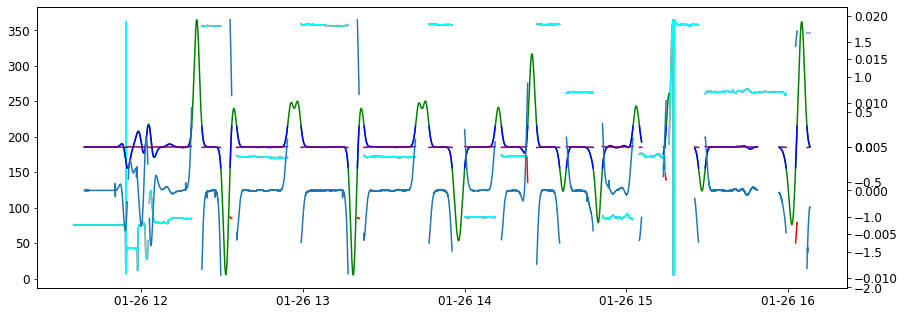

In [320]:
# HEADING


fig,ax = plt.subplots(figsize=(15,5))
# data.HEADING.plot()
HEADING_shift = (data.HEADING+5)%360-5
HEADING_shift = (data.HEADING-5)%360+5
# ax.plot(data.time,HEADING_shift)


HEADING_shift_smooth = gaussian_filter(HEADING_shift,60)
## first derivative
dH_smooth = np.append(np.diff(HEADING_shift_smooth),np.nan)
dH_smooth_2 = gaussian_filter(dH_smooth,0)
dHEADING = np.append(np.diff(HEADING_shift),np.nan)
ax_r = ax.twinx()
# ax_r.plot(data.time,dHEADING,'r')
# ax_r.plot(data.time,dH_smooth,'r')
# ax_r2 = ax.twinx()
ax_r.plot(data.time,dH_smooth_2,'g')

mask_dH = getVarMask(dH_smooth_2,0.3,outside=True)
ax_r.plot(data.time,applyMask(dH_smooth_2,mask_dH),'b')

ax.plot(data.time,applyMask(HEADING_shift,mask_dH),'r')

## second derivative
ddH = np.append(np.diff(dH_smooth_2),np.nan)
ddH_maskdH = applyMask(ddH,mask_dH)

ax_rr = ax.twinx()
ax_rr.plot(data.time,ddH_maskdH)

mask_ddH = getVarMask(ddH,0.008,outside=True)
mask_H = mergeMasks([mask_dH,mask_ddH])

ddH_maskdHddH = applyMask(ddH_maskdH,mask_ddH)
ax_r.plot(data.time,ddH_maskdHddH,'purple')

ax.plot(data.time,applyMask(HEADING_shift,mask_H),'cyan')



def maskChangeDirection(data,thres=0.3,thres2=0.008):
    
    # correct data for 0deg-360 matching
    var_shift = (data.HEADING+5)%360-5
    var_shift = (var_shift-5)%360+5
    
    # smooth before taking derivative
    dir_smooth = gaussian_filter(var_shift,60)
    # take derivative
    ddir = np.append(np.diff(dir_smooth),np.nan)
    # smooth after taking derivative
    ddir_smooth = gaussian_filter(ddir,0)
    # mask first derivative
    mask_ddir = getVarMask(ddir_smooth,thres,outside=True)
    # second derivative
    dddir = np.append(np.diff(ddir_smooth),np.nan)
    # mask second derivative
    mask_dddir = getVarMask(dddir,thres2,outside=True)
    # merge both masks
    mask = mergeMasks([mask_ddir,mask_dddir])
    
    return mask

/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


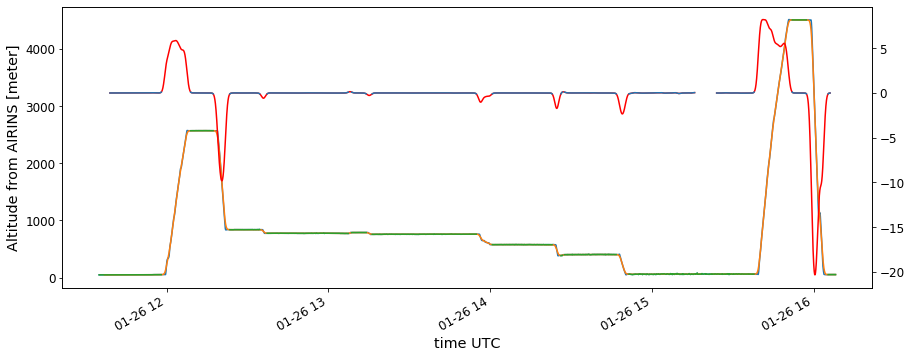

In [321]:
# ALTITUDE

fig,ax = plt.subplots(figsize=(15,5))
data.ALTITUDE.plot()

ax_r = ax.twinx()
z_smooth = gaussian_filter(data.ALTITUDE,30)
ax.plot(data.time,z_smooth)
dz_smooth = np.append(np.diff(z_smooth),np.nan)
dz_smooth_after = gaussian_filter(np.append(np.diff(data.ALTITUDE),np.nan),30)
dz_smooth_double = gaussian_filter(np.append(np.diff(z_smooth),np.nan),30)
dz = np.append(np.diff(data.ALTITUDE),np.nan)

ax_r.plot(data.time,dz_smooth_double,c='r')

mask_dz = getVarMask(dz_smooth_double,0.1,outside=True)
dz_smooth_double_m = dz_smooth_double
dz_smooth_double_m[mask_dz] = np.nan
ax_r.plot(data.time,dz_smooth_double_m)
ax.plot(data.time,applyMask(data.ALTITUDE,mask_dz))

def maskChangeAltitude(data,thres=0.1):
    
    # smooth before taking derivative
    z_smooth = gaussian_filter(data.ALTITUDE,30)
    # take derivative
    dz = np.append(np.diff(z_smooth),np.nan)
    # smooth after taking derivative
    dz_smooth = gaussian_filter(dz,30)
    # mask
    mask = getVarMask(dz_smooth,thres,outside=True)
    
    return mask
    
    

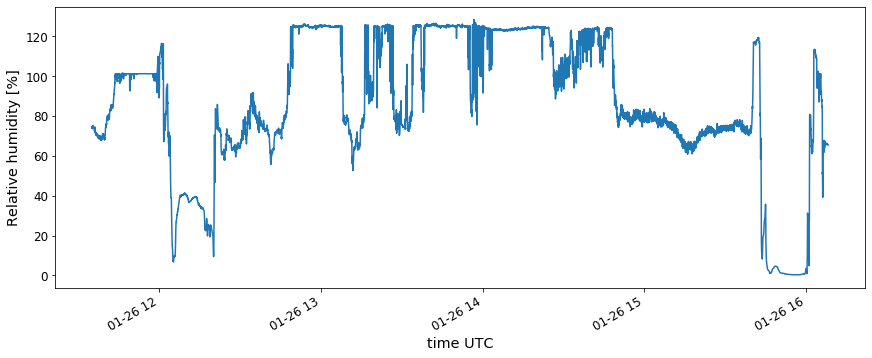

In [322]:
plt.figure(figsize=(15,5))
data.RH.plot()

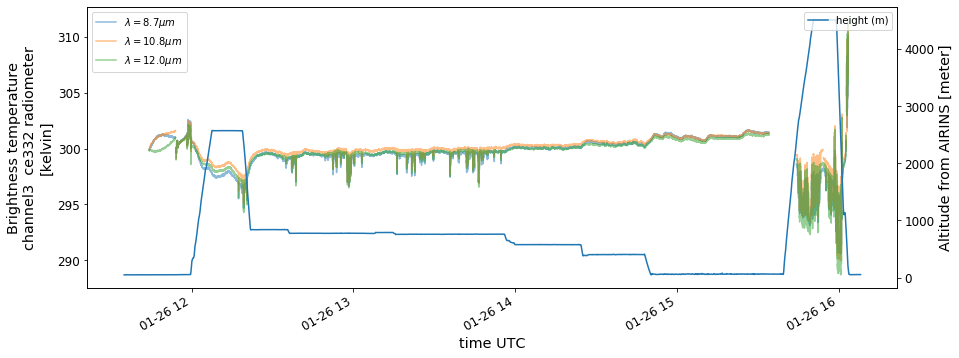

In [323]:
showTbAndZ(data)

/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:946: RuntimeWarning: Glyph 0 missing from current font.
  s, flags=LOAD_NO_SCALE | LOAD_NO_HINTING).horiAdvance
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:946: RuntimeWarning: Glyph 1 missing from current font.
  s, flags=LOAD_NO_SCALE | LOAD_NO_HINTING).horiAdvance
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:946: RuntimeWarning: Glyph 2 missing from current font.
  s, flags=LOAD_NO_SCALE | LOAD_NO_HINTING).horiAdvance
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:946: RuntimeWarning: Glyph 3 missing from current font.
  s, flags=LOAD_NO_SCAL

mask altitude changes
mask direction changes
mask both


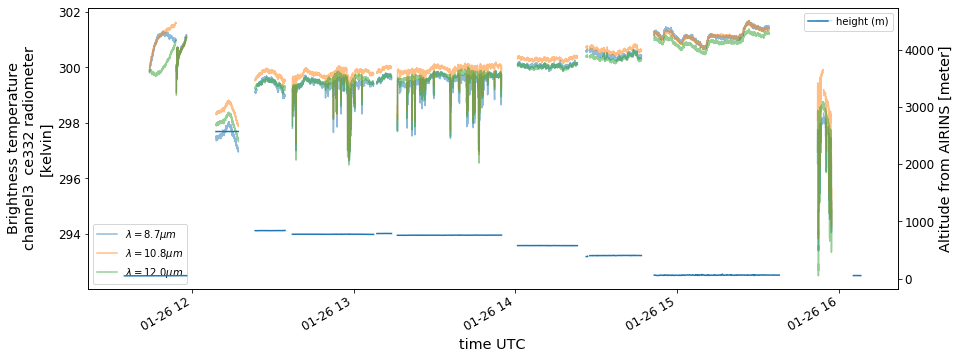

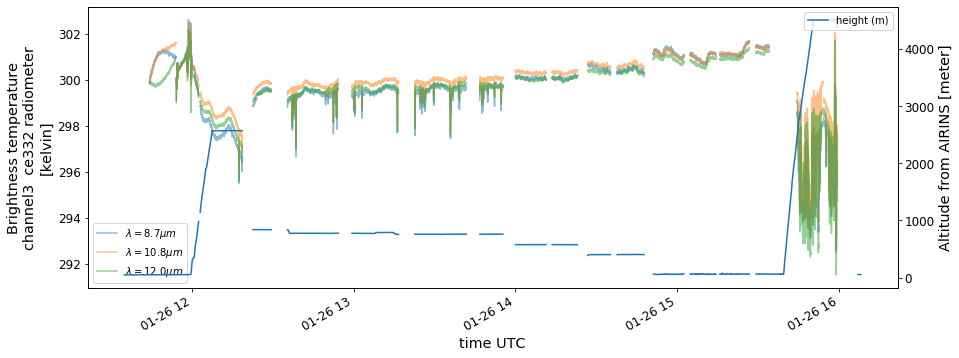

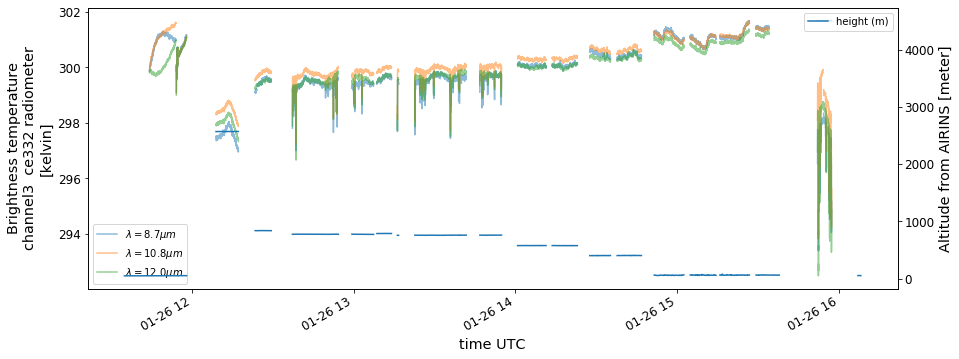

In [326]:
sl = slice(None)
# sl = slice(0,3000)

# mask when aircraft changes altitude (ALTITUDE)
mask_dz = maskChangeAltitude(data)

# mask when aircraft changes direction (HEADING)
mask_dd = maskChangeDirection(data)

mask_all = mergeMasks([mask_dz,mask_dd])

print('mask altitude changes')
showTbAndZ(data,between=sl,mask=mask_dz)
plt.savefig('mask_altitude_changes.pdf',bbox_inches='tight')
print('mask direction changes')
showTbAndZ(data,between=sl,mask=mask_dd)
plt.savefig('mask_direction_changes.pdf',bbox_inches='tight')
print('mask both')
showTbAndZ(data,between=sl,mask=mask_all)
plt.savefig('mask_altitude_and_direction_changes.pdf',bbox_inches='tight')

# Manually

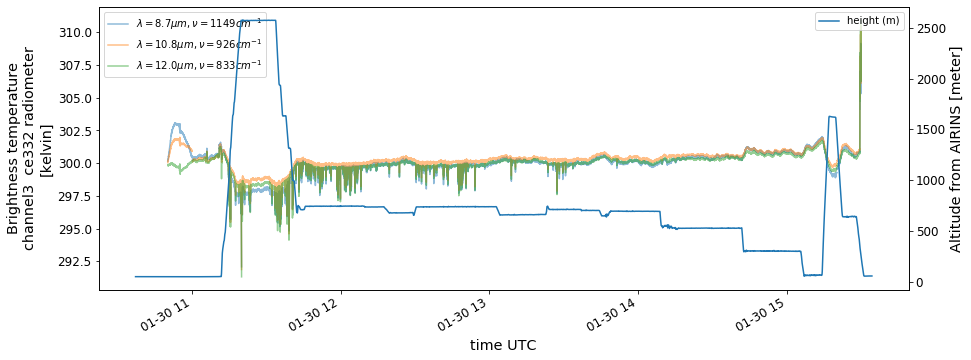

In [82]:
sl = slice(None)
# sl = slice(10,3000)
# sl = slice(2000,3000)

fig,ax = plt.subplots(figsize=(15,5))
labels = [r'$\lambda = %2.1f \mu m, \nu = %4.0f cm^{-1}$'%(lam,nu) for (lam,nu) in zip(wlengths,wnumbs)]
varids = ['BRIGHTNESS_TEMPERATURE_C1','BRIGHTNESS_TEMPERATURE_C2','BRIGHTNESS_TEMPERATURE_C3']
for i in range(3):
    data[varids[i]][sl].plot(alpha=0.5,label=labels[i])

ax_r = ax.twinx()
data.ALTITUDE[sl].plot(label='height (m)')

# ax_r2 = ax.twinx()
# data.RH[sl].plot(label='RH ()')

# i=2
# data[varids[i]].plot(alpha=0.5,label=labels[i])
ax.legend()
ax_r.legend(loc='upper right')
plt.show()

In [ ]:
sl = slice(None)
# sl = slice(10,3000)
# sl = slice(2000,3000)

fig,ax = plt.subplots(figsize=(15,5))
labels = [r'$\lambda = %2.1f \mu m, \nu = %4.0f cm^{-1}$'%(lam,nu) for (lam,nu) in zip(wlengths,wnumbs)]
varids = ['BRIGHTNESS_TEMPERATURE_C1','BRIGHTNESS_TEMPERATURE_C2','BRIGHTNESS_TEMPERATURE_C3']
for i in range(3):
    data[varids[i]][sl].plot(alpha=0.5,label=labels[i])

ax_r = ax.twinx()
data.ALTITUDE[sl].plot(label='height (m)')

# ax_r2 = ax.twinx()
# data.RH[sl].plot(label='RH ()')

# i=2
# data[varids[i]].plot(alpha=0.5,label=labels[i])
ax.legend(loc='upper center')
ax_r.legend(loc='upper right')
plt.show()

Procedure:

- mask cloudy points
- correct for height


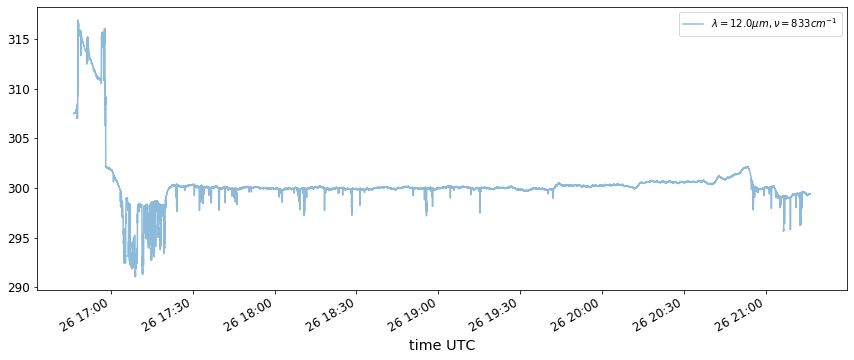

In [27]:
plt.figure(figsize=(15,5))
labels = [r'$\lambda = %2.1f \mu m, \nu = %4.0f cm^{-1}$'%(lam,nu) for (lam,nu) in zip(wlengths,wnumbs)]
varids = ['BRIGHTNESS_TEMPERATURE_C1','BRIGHTNESS_TEMPERATURE_C2','BRIGHTNESS_TEMPERATURE_C3']

((data[varids[0]]+data[varids[1]]+data[varids[2]])/3).plot(alpha=0.5,label=labels[i])

plt.legend()
plt.show()

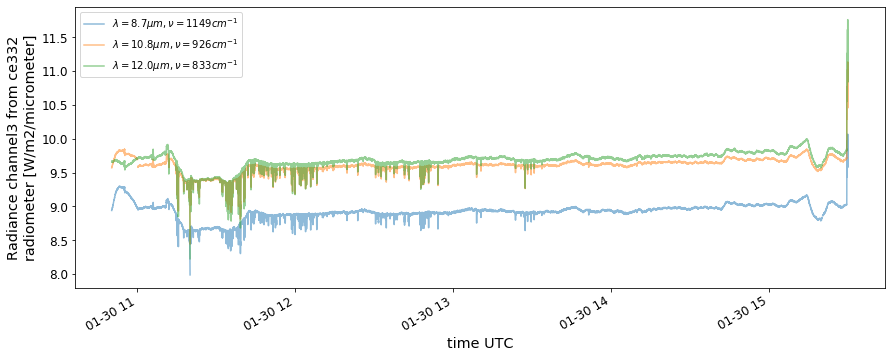

In [36]:
plt.figure(figsize=(15,5))
varids = ['RADIANCE_C1','RADIANCE_C2','RADIANCE_C3']
for i in range(3):
    data[varids[i]].plot(alpha=0.5,label=labels[i])
plt.legend()
plt.show()

In [16]:
data

<xarray.Dataset>
Dimensions:                    (level: 2, time: 21564)
Coordinates:
  * time                       (time) datetime64[ns] 2020-01-30T09:35:00.760126 ... 2020-01-30T15:34:24.760022
Dimensions without coordinates: level
Data variables:
    time_bnds                  (time, level) datetime64[ns] ...
    LATITUDE                   (time) float32 ...
    LONGITUDE                  (time) float32 ...
    ALTITUDE                   (time) float32 ...
    ROLL                       (time) float32 ...
    PITCH                      (time) float32 ...
    HEADING                    (time) float32 ...
    RH                         (time) float32 ...
    BRIGHTNESS_TEMPERATURE_C1  (time) float32 nan nan nan nan ... nan nan nan
    BRIGHTNESS_TEMPERATURE_C2  (time) float32 ...
    BRIGHTNESS_TEMPERATURE_C3  (time) float32 ...
    RADIANCE_C1                (time) float32 ...
    RADIANCE_C2                (time) float32 ...
    RADIANCE_C3                (time) float32 ...
Attribut